### Stock Trading Strategy using Classification Algorithms to Predict Market Movements and Backtesting

In [1]:
# make the necessary imports 
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import yfinance as yf
import warnings
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import datetime
import pyfolio as pf
import backtrader as bt
from backtrader.feeds import PandasData
import warnings

# set the style and ignore warnings
plt.style.use('seaborn-colorblind')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

C:\ProgramData\Anaconda3\lib\site-packages\pyfolio\pos.py:27: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  'Module "zipline.assets" not found; multipliers will not be applied'


In [2]:
# this is to display images in notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Data Gathering

In [3]:
# ticker and the start and end dates for testing
ticker =  '^NSEI' # Nifty 50 benchmark
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2020, 7, 31)

In [5]:
# download ticker ‘Adj Close’ price from yahoo finance
stock =  yf.download(ticker, progress=True, actions=True,start=start, end=end)['Adj Close']
stock = pd.DataFrame(stock)
stock.rename(columns = {'Adj Close':ticker}, inplace=True)
stock.head(2)

[*********************100%***********************]  1 of 1 completed


,^NSEI
Date,
2010-01-04,5232.200195
2010-01-05,5277.899902


In [6]:
# calculate daily log returns and market direction
stock['returns'] = np.log(stock / stock.shift(1))
stock.dropna(inplace=True)
stock['direction'] = np.sign(stock['returns']).astype(int)
stock.head(3)

,^NSEI,returns,direction
Date,,,
2010-01-05,5277.899902,0.008696,1
2010-01-06,5281.799805,0.000739,1
2010-01-07,5263.100098,-0.003547,-1


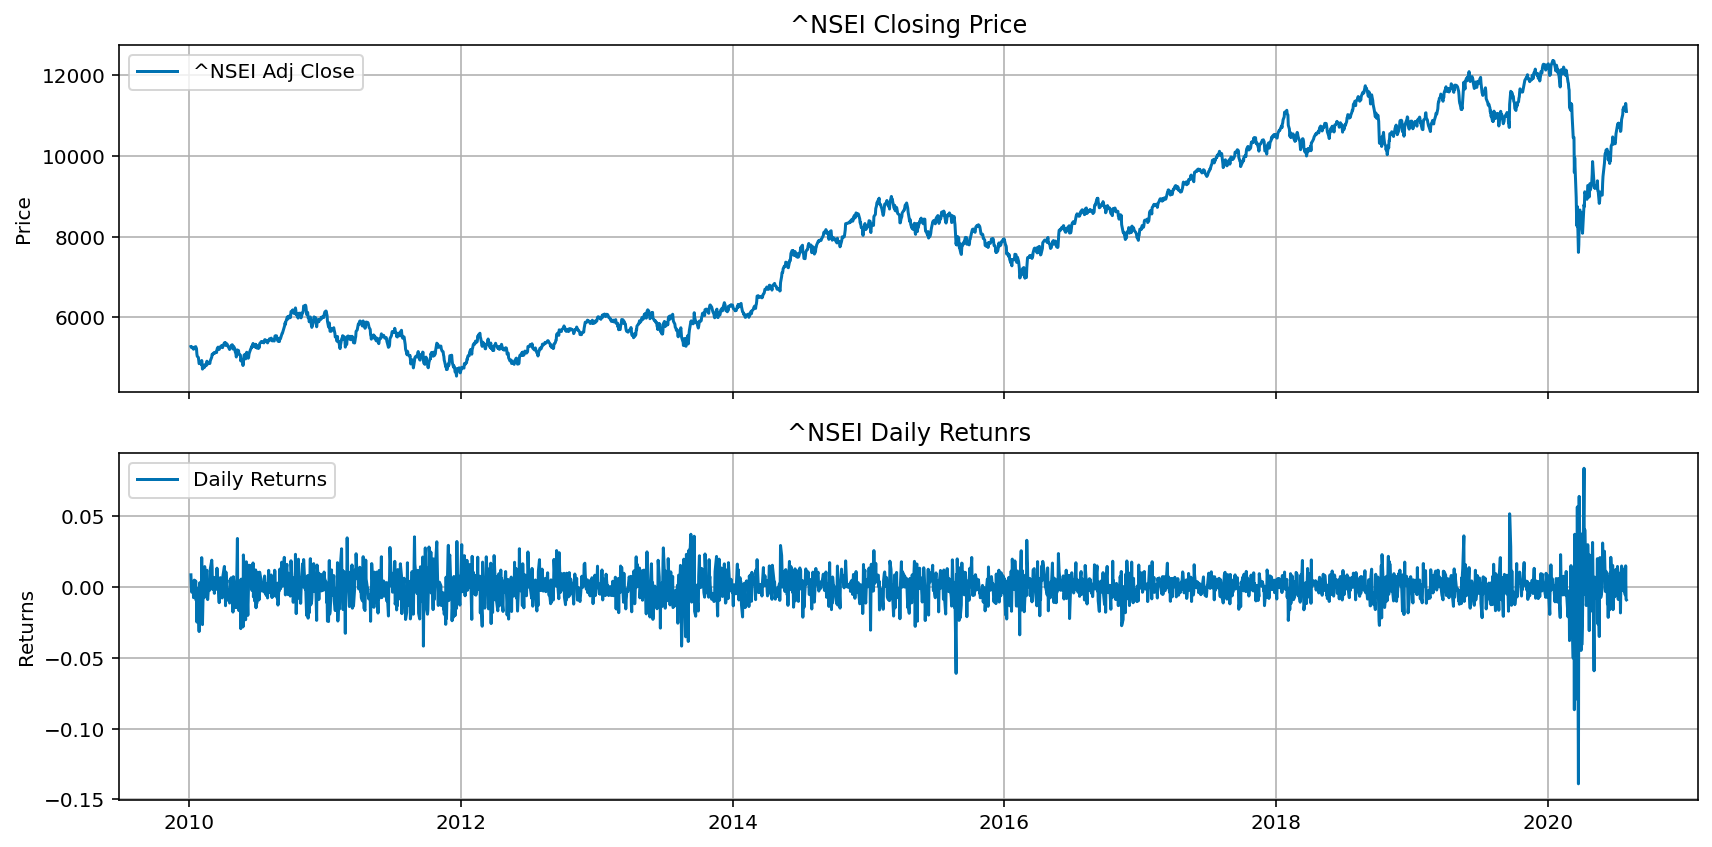

In [7]:
# visualize the closing price and daily returns
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (12,6))
ax[0].plot(stock[ticker], label = f'{ticker} Adj Close')
ax[0].set(title = f'{ticker} Closing Price', ylabel = 'Price')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(stock['returns'], label = 'Daily Returns')
ax[1].set(title = f'{ticker} Daily Retunrs', ylabel = 'Returns')
ax[1].grid(True)
plt.legend()

plt.tight_layout();
plt.savefig('images/chart1', dpi=300)

### Feature Engineering

In [8]:
# define the number of lags
lags = [1, 2, 3, 4, 5]

In [9]:
# compute lagged log returns
cols = []
for lag in lags:
    col = f'rtn_lag{lag}'
    stock[col] = stock['returns'].shift(lag)
    cols.append(col)

stock.dropna(inplace=True)
stock.head(2)

,^NSEI,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5
Date,,,,,,,,
2010-01-12,5210.399902,-0.007457,-1,0.000886,-0.003493,-0.003547,0.000739,0.008696
2010-01-13,5233.950195,0.004510,1,-0.007457,0.000886,-0.003493,-0.003547,0.000739


In [11]:
# cols

In [12]:
# function to transform the lag returns to binary values (0,+1)
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)  
        cols_bin.append(col_bin)

In [13]:
create_bins(stock)
stock[cols+cols_bin].head(2)

,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rtn_lag1_bin,rtn_lag2_bin,rtn_lag3_bin,rtn_lag4_bin,rtn_lag5_bin
Date,,,,,,,,,,
2010-01-12,0.000886,-0.003493,-0.003547,0.000739,0.008696,1,0,0,1,1
2010-01-13,-0.007457,0.000886,-0.003493,-0.003547,0.000739,0,1,0,0,1


In [14]:
# cols_bin

### Build and Apply Classification Machine Learning Algorithms

Select Logistic regression, Gaussian Naive Bayes, Support Vector Machine, Random Forest, and MLP Classifier approaches to predict the market direction. Please refer sklearn documentation for detail on these and other algorithms.
https://scikit-learn.org/stable/index.html

In [16]:
# create a dictionary of selected algorithms
models = {
    'log_reg': linear_model.LogisticRegression(),
    'gauss_nb': GaussianNB(),
    'svm': SVC(),
    'random_forest': RandomForestClassifier(max_depth=10, n_estimators=100),
    'MLP' : MLPClassifier(max_iter=500),
}

In [17]:
# function that fits all models.
def fit_models(data):  
    mfit = {model: models[model].fit(data[cols_bin], data['direction']) for model in models.keys()} 

In [18]:
# function that predicts (derives all position values) from the fitted models
def derive_positions(data):  
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])

In [19]:
# function to evaluate all trading strategies
def evaluate_strats(data):  
    global strategy_rtn
    strategy_rtn = []
    for model in models.keys():
        col = 'strategy_' + model 
        data[col] = data['pos_' + model] * data['returns']
        strategy_rtn.append(col)
    strategy_rtn.insert(0, 'returns')

In [20]:
# fit the models
fit_models(stock)

In [21]:
# derives all position values
derive_positions(stock)

In [22]:
# evaluate all trading strategies by multiplying predicted directions to actual daily returns
evaluate_strats(stock)

In [23]:
# calculate total return and std. deviation of each strategy
print('\nTotal Returns:')
print(stock[strategy_rtn].sum().apply(np.exp))
print('\nAnnual Volatility:')
stock[strategy_rtn].std() * 252 ** 0.5


Total Returns:
returns                   2.114937
strategy_log_reg          2.039876
strategy_gauss_nb         1.550421
strategy_svm              8.863971
strategy_random_forest    8.204446
strategy_MLP              5.781490
dtype: float64

Annual Volatility:


returns                   0.177054
strategy_log_reg          0.177059
strategy_gauss_nb         0.128479
strategy_svm              0.176605
strategy_random_forest    0.176641
strategy_MLP              0.176785
dtype: float64

In [24]:
# number of trades over time for highest and second highest return strategy
print('Number of trades SVM = ', (stock['pos_svm'].diff()!=0).sum())
print('Number of trades Ramdom Forest = ',(stock['pos_random_forest'].diff()!=0).sum())

Number of trades SVM =  1109
Number of trades Ramdom Forest =  953


In [25]:
# stock[[ticker]+ strategy_rtn].head(2)

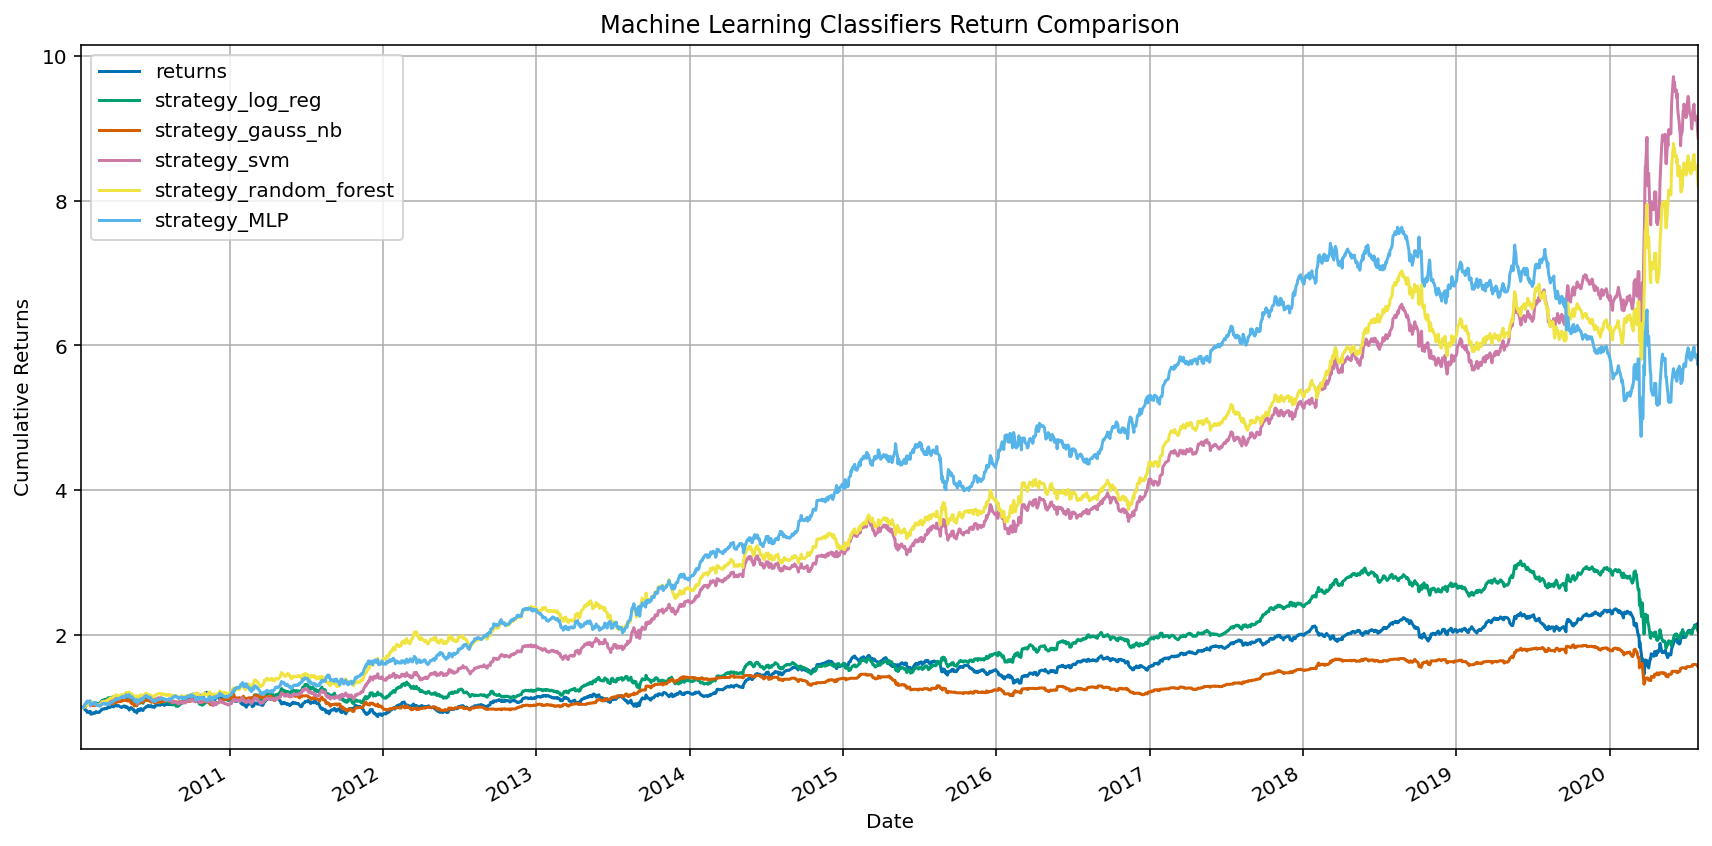

In [26]:
# vectorized backtesting of the resulting trading strategies and visualize the performance over time
ax = stock[strategy_rtn].cumsum().apply(np.exp).plot(figsize=(12, 6), 
                                                     title = 'Machine Learning Classifiers Return Comparison')
ax.set_ylabel("Cumulative Returns")
ax.grid(True);
plt.tight_layout();
plt.savefig('images/chart2', dpi=300)

### Backtesting of Selected Strategy using Backtrader

In [29]:
# fetch the daily pricing data from yahoo finance
prices =  yf.download(ticker, progress=True, actions=True, start=start, end=end)
prices.head(2)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2010-01-04,5200.899902,5238.450195,5167.100098,5232.200195,5232.200195,0,0,0
2010-01-05,5277.149902,5288.350098,5242.399902,5277.899902,5277.899902,0,0,0


In [30]:
# rename the columns as needed for Backtrader
prices.drop(['Close','Dividends','Stock Splits'], inplace=True, axis=1)
prices.rename(columns = {'Open':'open','High':'high','Low':'low','Adj Close':'close','Volume':'volume',
                         }, inplace=True)

In [31]:
prices.head(3)

,open,high,low,close,volume
Date,,,,,
2010-01-04,5200.899902,5238.450195,5167.100098,5232.200195,0
2010-01-05,5277.149902,5288.350098,5242.399902,5277.899902,0
2010-01-06,5278.149902,5310.850098,5260.049805,5281.799805,0


In [32]:
# add the predicted column to prices dataframe. This will be used as signal for buy or sell
predictions = stock['strategy_svm']
predictions = pd.DataFrame(predictions)
predictions.rename(columns = {'strategy_svm':'predicted'}, inplace=True)
prices = predictions.join(prices, how='right').dropna()
prices.head(2)

,predicted,open,high,low,close,volume
Date,,,,,,
2010-01-12,-0.007457,5251.100098,5300.500000,5200.950195,5210.399902,0
2010-01-13,0.004510,5212.600098,5239.200195,5169.549805,5233.950195,0


In [33]:
# prices[['predicted']].sum().apply(np.exp)

In [34]:
OHLCV = ['open', 'high', 'low', 'close', 'volume']

In [35]:
# class to define the columns we will provide
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predicted']

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

Strategy: 
1.	Buy when the predicted value is +1 and sell (only if stock is in possession) when the predicted value is -1.
2.	All-in strategy—when creating a buy order, buy as many shares as possible.
3.	Short selling is not allowed

In [36]:
# define backtesting strategy class
class MLStrategy(bt.Strategy):
    params = dict(
    )
    
    def __init__(self):
        # keep track of open, close prices and predicted value in the series
        self.data_predicted = self.datas[0].predicted
        self.data_open = self.datas[0].open
        self.data_close = self.datas[0].close
        
        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

    # logging function
    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )

        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    # We have set cheat_on_open = True.This means that we calculated the signals on day t's close price, 
    # but calculated the number of shares we wanted to buy based on day t+1's open price.
    def next_open(self):
        if not self.position:
            if self.data_predicted > 0:
                # calculate the max number of shares ('all-in')
                size = int(self.broker.getcash() / self.datas[0].open)
                # buy order
                self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.buy(size=size)
        else:
            if self.data_predicted < 0:
                # sell order
                self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)

In [37]:
# instantiate SignalData class
data = SignalData(dataname=prices)

In [38]:
# instantiate Cerebro, add strategy, data, initial cash, commission and pyfolio for performance analysis
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)
cerebro.addstrategy(MLStrategy)
cerebro.adddata(data, name=ticker)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

In [39]:
# run the backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2010-01-13, BUY CREATED --- Size: 19, Cash: 100000.00, Open: 5212.60009765625, Close: 5233.9501953125
2010-01-13, BUY EXECUTED --- Price: 5212.60, Cost: 99039.40,Commission: 99.04
2010-01-15, SELL CREATED --- Size: 19
2010-01-15, SELL EXECUTED --- Price: 5259.90, Cost: 99039.40,Commission: 99.94
2010-01-15, OPERATION RESULT --- Gross: 898.70, Net: 699.72
2010-01-18, BUY CREATED --- Size: 19, Cash: 100699.72, Open: 5253.64990234375, Close: 5274.85009765625
2010-01-18, BUY EXECUTED --- Price: 5253.65, Cost: 99819.35,Commission: 99.82
2010-01-19, SELL CREATED --- Size: 19
2010-01-19, SELL EXECUTED --- Price: 5274.20, Cost: 99819.35,Commission: 100.21
2010-01-19, OPERATION RESULT --- Gross: 390.46, Net: 190.43
2010-01-20, BUY CREATED --- Size: 19, Cash: 100890.15, Open: 5226.10009765625, Close: 5221.7001953125
2010-01-20, BUY EXECUTED --- Price: 5226.10, Cost: 99295.90,Commission: 99.30
2010-01-28, SELL CREATED --- Size: 19
2010-01-28, SELL EXECUTED --- 

2010-12-07, SELL EXECUTED --- Price: 5995.05, Cost: 105678.00,Commission: 107.91
2010-12-07, OPERATION RESULT --- Gross: 2232.90, Net: 2019.31
2010-12-08, BUY CREATED --- Size: 18, Cash: 110015.52, Open: 5954.39990234375, Close: 5903.7001953125
2010-12-08, BUY EXECUTED --- Price: 5954.40, Cost: 107179.20,Commission: 107.18
2010-12-10, SELL CREATED --- Size: 18
2010-12-10, SELL EXECUTED --- Price: 5761.00, Cost: 107179.20,Commission: 103.70
2010-12-10, OPERATION RESULT --- Gross: -3481.20, Net: -3692.08
2010-12-14, BUY CREATED --- Size: 17, Cash: 106323.45, Open: 5928.7001953125, Close: 5944.10009765625
2010-12-14, BUY EXECUTED --- Price: 5928.70, Cost: 100787.90,Commission: 100.79
2010-12-15, SELL CREATED --- Size: 17
2010-12-15, SELL EXECUTED --- Price: 5931.15, Cost: 100787.90,Commission: 100.83
2010-12-15, OPERATION RESULT --- Gross: 41.65, Net: -159.97
2010-12-23, BUY CREATED --- Size: 17, Cash: 106163.48, Open: 6005.89990234375, Close: 5980.0
2010-12-23, BUY EXECUTED --- Price: 60

2011-06-07, BUY EXECUTED --- Price: 5509.15, Cost: 88146.40,Commission: 88.15
2011-06-08, SELL CREATED --- Size: 16
2011-06-08, SELL EXECUTED --- Price: 5535.25, Cost: 88146.40,Commission: 88.56
2011-06-08, OPERATION RESULT --- Gross: 417.60, Net: 240.89
2011-06-10, BUY CREATED --- Size: 16, Cash: 90850.99, Open: 5518.0498046875, Close: 5485.7998046875
2011-06-10, BUY EXECUTED --- Price: 5518.05, Cost: 88288.80,Commission: 88.29
2011-06-14, SELL CREATED --- Size: 16
2011-06-14, SELL EXECUTED --- Price: 5485.60, Cost: 88288.80,Commission: 87.77
2011-06-14, OPERATION RESULT --- Gross: -519.20, Net: -695.25
2011-06-15, BUY CREATED --- Size: 16, Cash: 90155.73, Open: 5494.4501953125, Close: 5447.5
2011-06-15, BUY EXECUTED --- Price: 5494.45, Cost: 87911.20,Commission: 87.91
2011-06-16, SELL CREATED --- Size: 16
2011-06-16, SELL EXECUTED --- Price: 5419.65, Cost: 87911.20,Commission: 86.71
2011-06-16, OPERATION RESULT --- Gross: -1196.80, Net: -1371.43
2011-06-17, BUY CREATED --- Size: 16, 

2012-03-19, SELL CREATED --- Size: 15
2012-03-19, SELL EXECUTED --- Price: 5337.35, Cost: 81301.50,Commission: 80.06
2012-03-19, OPERATION RESULT --- Gross: -1241.25, Net: -1402.61
2012-03-21, BUY CREATED --- Size: 16, Cash: 84629.14, Open: 5267.2001953125, Close: 5364.9501953125
2012-03-21, BUY EXECUTED --- Price: 5267.20, Cost: 84275.20,Commission: 84.28
2012-03-22, SELL CREATED --- Size: 16
2012-03-22, SELL EXECUTED --- Price: 5361.10, Cost: 84275.20,Commission: 85.78
2012-03-22, OPERATION RESULT --- Gross: 1502.40, Net: 1332.35
2012-03-23, BUY CREATED --- Size: 16, Cash: 85961.48, Open: 5255.64990234375, Close: 5278.2001953125
2012-03-23, BUY EXECUTED --- Price: 5255.65, Cost: 84090.40,Commission: 84.09
2012-03-26, SELL CREATED --- Size: 16
2012-03-26, SELL EXECUTED --- Price: 5274.35, Cost: 84090.40,Commission: 84.39
2012-03-26, OPERATION RESULT --- Gross: 299.20, Net: 130.72
2012-03-29, BUY CREATED --- Size: 16, Cash: 86092.21, Open: 5145.9501953125, Close: 5178.85009765625
2012-

2013-02-06, OPERATION RESULT --- Gross: -793.51, Net: -973.94
2013-02-07, BUY CREATED --- Size: 16, Cash: 95116.06, Open: 5936.4501953125, Close: 5938.7998046875
2013-02-07, BUY EXECUTED --- Price: 5936.45, Cost: 94983.20,Commission: 94.98
2013-02-08, SELL CREATED --- Size: 16
2013-02-08, SELL EXECUTED --- Price: 5929.10, Cost: 94983.20,Commission: 94.87
2013-02-08, OPERATION RESULT --- Gross: -117.60, Net: -307.45
2013-02-11, BUY CREATED --- Size: 16, Cash: 94808.60, Open: 5920.0498046875, Close: 5897.85009765625
2013-02-11, Order Failed
2013-02-13, BUY CREATED --- Size: 15, Cash: 94808.60, Open: 5943.14990234375, Close: 5932.9501953125
2013-02-13, BUY EXECUTED --- Price: 5943.15, Cost: 89147.25,Commission: 89.15
2013-02-14, SELL CREATED --- Size: 15
2013-02-14, SELL EXECUTED --- Price: 5933.20, Cost: 89147.25,Commission: 89.00
2013-02-14, OPERATION RESULT --- Gross: -149.25, Net: -327.39
2013-02-19, BUY CREATED --- Size: 16, Cash: 94481.21, Open: 5900.2001953125, Close: 5939.70019531

2014-06-16, BUY CREATED --- Size: 14, Cash: 106915.96, Open: 7534.7998046875, Close: 7533.5498046875
2014-06-16, BUY EXECUTED --- Price: 7534.80, Cost: 105487.20,Commission: 105.49
2014-06-17, SELL CREATED --- Size: 14
2014-06-17, SELL EXECUTED --- Price: 7525.05, Cost: 105487.20,Commission: 105.35
2014-06-17, OPERATION RESULT --- Gross: -136.50, Net: -347.34
2014-06-20, BUY CREATED --- Size: 14, Cash: 106568.62, Open: 7543.2998046875, Close: 7511.4501953125
2014-06-20, BUY EXECUTED --- Price: 7543.30, Cost: 105606.20,Commission: 105.61
2014-06-24, SELL CREATED --- Size: 14
2014-06-24, SELL EXECUTED --- Price: 7515.20, Cost: 105606.20,Commission: 105.21
2014-06-24, OPERATION RESULT --- Gross: -393.39, Net: -604.21
2014-06-25, BUY CREATED --- Size: 13, Cash: 105964.41, Open: 7588.5498046875, Close: 7569.25
2014-06-25, BUY EXECUTED --- Price: 7588.55, Cost: 98651.15,Commission: 98.65
2014-06-26, SELL CREATED --- Size: 13
2014-06-26, SELL EXECUTED --- Price: 7554.10, Cost: 98651.15,Commis

2015-05-07, BUY EXECUTED --- Price: 8077.00, Cost: 113078.00,Commission: 113.08
2015-05-08, SELL CREATED --- Size: 14
2015-05-08, SELL EXECUTED --- Price: 8131.50, Cost: 113078.00,Commission: 113.84
2015-05-08, OPERATION RESULT --- Gross: 763.00, Net: 536.08
2015-05-11, BUY CREATED --- Size: 14, Cash: 118733.87, Open: 8243.2001953125, Close: 8325.25
2015-05-11, BUY EXECUTED --- Price: 8243.20, Cost: 115404.80,Commission: 115.40
2015-05-12, SELL CREATED --- Size: 14
2015-05-12, SELL EXECUTED --- Price: 8326.15, Cost: 115404.80,Commission: 116.57
2015-05-12, OPERATION RESULT --- Gross: 1161.30, Net: 929.33
2015-05-13, BUY CREATED --- Size: 14, Cash: 119663.20, Open: 8181.5498046875, Close: 8235.4501953125
2015-05-13, BUY EXECUTED --- Price: 8181.55, Cost: 114541.70,Commission: 114.54
2015-05-14, SELL CREATED --- Size: 14
2015-05-14, SELL EXECUTED --- Price: 8232.45, Cost: 114541.70,Commission: 115.25
2015-05-14, OPERATION RESULT --- Gross: 712.61, Net: 482.81
2015-05-18, BUY CREATED --- 

2016-06-21, SELL CREATED --- Size: 15
2016-06-21, SELL EXECUTED --- Price: 8255.40, Cost: 122709.75,Commission: 123.83
2016-06-21, OPERATION RESULT --- Gross: 1121.26, Net: 874.72
2016-06-27, BUY CREATED --- Size: 15, Cash: 124382.82, Open: 8039.35009765625, Close: 8094.7001953125
2016-06-27, BUY EXECUTED --- Price: 8039.35, Cost: 120590.25,Commission: 120.59
2016-07-01, SELL CREATED --- Size: 15
2016-07-01, SELL EXECUTED --- Price: 8313.05, Cost: 120590.25,Commission: 124.70
2016-07-01, OPERATION RESULT --- Gross: 4105.50, Net: 3860.21
2016-07-04, BUY CREATED --- Size: 15, Cash: 128243.03, Open: 8376.75, Close: 8370.7001953125
2016-07-04, BUY EXECUTED --- Price: 8376.75, Cost: 125651.25,Commission: 125.65
2016-07-05, SELL CREATED --- Size: 15
2016-07-05, SELL EXECUTED --- Price: 8379.30, Cost: 125651.25,Commission: 125.69
2016-07-05, OPERATION RESULT --- Gross: 38.25, Net: -213.09
2016-07-12, BUY CREATED --- Size: 15, Cash: 128029.93, Open: 8502.599609375, Close: 8521.0498046875
2016-

2017-04-21, BUY EXECUTED --- Price: 9179.10, Cost: 137686.49,Commission: 137.69
2017-04-27, SELL CREATED --- Size: 15
2017-04-27, SELL EXECUTED --- Price: 9359.15, Cost: 137686.49,Commission: 140.39
2017-04-27, OPERATION RESULT --- Gross: 2700.76, Net: 2422.69
2017-04-28, BUY CREATED --- Size: 15, Cash: 141055.37, Open: 9340.9501953125, Close: 9304.0498046875
2017-04-28, BUY EXECUTED --- Price: 9340.95, Cost: 140114.25,Commission: 140.11
2017-05-03, SELL CREATED --- Size: 15
2017-05-03, SELL EXECUTED --- Price: 9344.70, Cost: 140114.25,Commission: 140.17
2017-05-03, OPERATION RESULT --- Gross: 56.25, Net: -224.03
2017-05-04, BUY CREATED --- Size: 15, Cash: 140831.34, Open: 9360.9501953125, Close: 9359.900390625
2017-05-04, BUY EXECUTED --- Price: 9360.95, Cost: 140414.25,Commission: 140.41
2017-05-05, SELL CREATED --- Size: 15
2017-05-05, SELL EXECUTED --- Price: 9374.55, Cost: 140414.25,Commission: 140.62
2017-05-05, OPERATION RESULT --- Gross: 203.99, Net: -77.04
2017-05-09, BUY CREA

2018-02-14, SELL CREATED --- Size: 13
2018-02-14, SELL EXECUTED --- Price: 10585.75, Cost: 135414.50,Commission: 137.61
2018-02-14, OPERATION RESULT --- Gross: 2200.25, Net: 1927.22
2018-02-19, BUY CREATED --- Size: 13, Cash: 139767.32, Open: 10488.900390625, Close: 10378.400390625
2018-02-19, BUY EXECUTED --- Price: 10488.90, Cost: 136355.71,Commission: 136.36
2018-02-21, SELL CREATED --- Size: 13
2018-02-21, SELL EXECUTED --- Price: 10426.00, Cost: 136355.71,Commission: 135.54
2018-02-21, OPERATION RESULT --- Gross: -817.71, Net: -1089.60
2018-02-23, BUY CREATED --- Size: 13, Cash: 138677.72, Open: 10408.099609375, Close: 10491.0498046875
2018-02-23, BUY EXECUTED --- Price: 10408.10, Cost: 135305.29,Commission: 135.31
2018-02-27, SELL CREATED --- Size: 13
2018-02-27, SELL EXECUTED --- Price: 10615.20, Cost: 135305.29,Commission: 138.00
2018-02-27, OPERATION RESULT --- Gross: 2692.31, Net: 2419.00
2018-03-01, BUY CREATED --- Size: 13, Cash: 141096.72, Open: 10479.9501953125, Close: 10

2019-02-04, BUY EXECUTED --- Price: 10876.75, Cost: 141397.75,Commission: 141.40
2019-02-06, SELL CREATED --- Size: 13
2019-02-06, SELL EXECUTED --- Price: 10965.10, Cost: 141397.75,Commission: 142.55
2019-02-06, OPERATION RESULT --- Gross: 1148.54, Net: 864.60
2019-02-07, BUY CREATED --- Size: 13, Cash: 146012.30, Open: 11070.4501953125, Close: 11069.400390625
2019-02-07, BUY EXECUTED --- Price: 11070.45, Cost: 143915.85,Commission: 143.92
2019-02-08, SELL CREATED --- Size: 13
2019-02-08, SELL EXECUTED --- Price: 11023.50, Cost: 143915.85,Commission: 143.31
2019-02-08, OPERATION RESULT --- Gross: -610.35, Net: -897.57
2019-02-11, BUY CREATED --- Size: 13, Cash: 145114.73, Open: 10930.900390625, Close: 10888.7998046875
2019-02-11, BUY EXECUTED --- Price: 10930.90, Cost: 142101.71,Commission: 142.10
2019-02-12, SELL CREATED --- Size: 13
2019-02-12, SELL EXECUTED --- Price: 10879.70, Cost: 142101.71,Commission: 141.44
2019-02-12, OPERATION RESULT --- Gross: -665.60, Net: -949.14
2019-02-

2019-11-15, BUY EXECUTED --- Price: 11904.20, Cost: 142850.40,Commission: 142.85
2019-11-18, SELL CREATED --- Size: 12
2019-11-18, SELL EXECUTED --- Price: 11915.15, Cost: 142850.40,Commission: 142.98
2019-11-18, OPERATION RESULT --- Gross: 131.40, Net: -154.43
2019-11-19, BUY CREATED --- Size: 12, Cash: 145474.90, Open: 11919.4501953125, Close: 11940.099609375
2019-11-19, BUY EXECUTED --- Price: 11919.45, Cost: 143033.40,Commission: 143.03
2019-11-21, SELL CREATED --- Size: 12
2019-11-21, SELL EXECUTED --- Price: 12025.65, Cost: 143033.40,Commission: 144.31
2019-11-21, OPERATION RESULT --- Gross: 1274.40, Net: 987.06
2019-11-27, BUY CREATED --- Size: 12, Cash: 146461.97, Open: 12068.5, Close: 12100.7001953125
2019-11-27, BUY EXECUTED --- Price: 12068.50, Cost: 144822.00,Commission: 144.82
2019-11-29, SELL CREATED --- Size: 12
2019-11-29, SELL EXECUTED --- Price: 12146.20, Cost: 144822.00,Commission: 145.75
2019-11-29, OPERATION RESULT --- Gross: 932.40, Net: 641.83
2019-12-03, BUY CRE

2020-06-02, SELL EXECUTED --- Price: 9880.85, Cost: 127396.50,Commission: 138.33
2020-06-02, OPERATION RESULT --- Gross: 10935.39, Net: 10669.67
2020-06-03, BUY CREATED --- Size: 13, Cash: 141251.01, Open: 10108.2998046875, Close: 10061.5498046875
2020-06-03, BUY EXECUTED --- Price: 10108.30, Cost: 131407.90,Commission: 131.41
2020-06-04, SELL CREATED --- Size: 13
2020-06-04, SELL EXECUTED --- Price: 10054.25, Cost: 131407.90,Commission: 130.71
2020-06-04, OPERATION RESULT --- Gross: -702.65, Net: -964.76
2020-06-08, BUY CREATED --- Size: 13, Cash: 140286.25, Open: 10326.75, Close: 10167.4501953125
2020-06-08, BUY EXECUTED --- Price: 10326.75, Cost: 134247.75,Commission: 134.25
2020-06-09, SELL CREATED --- Size: 13
2020-06-09, SELL EXECUTED --- Price: 10181.15, Cost: 134247.75,Commission: 132.35
2020-06-09, OPERATION RESULT --- Gross: -1892.79, Net: -2159.40
2020-06-10, BUY CREATED --- Size: 13, Cash: 138126.86, Open: 10072.599609375, Close: 10116.150390625
2020-06-10, BUY EXECUTED ---

In [41]:
# Extract inputs for pyfolio
strat = backtest_result[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.name = 'Strategy'
returns.head(2)

index
2010-01-12 00:00:00+00:00    0.000000
2010-01-13 00:00:00+00:00    0.003066
Name: Strategy, dtype: float64

In [42]:
# get benchmark returns
benchmark_rets= stock['returns']
benchmark_rets.index = benchmark_rets.index.tz_localize('UTC') 
benchmark_rets = benchmark_rets.filter(returns.index)
benchmark_rets.name = 'Nifty-50'
benchmark_rets.head(2)

Date
2010-01-12 00:00:00+00:00   -0.007457
2010-01-13 00:00:00+00:00    0.004510
Name: Nifty-50, dtype: float64

In [43]:
# get performance statistics for strategy
pf.show_perf_stats(returns)

Start date,2010-01-12
End date,2020-07-30
Total months,123
,Backtest
Annual return,3.906%
Cumulative returns,48.1%
Annual volatility,12.613%
Sharpe ratio,0.37
Calmar ratio,0.12
Stability,0.75
Max drawdown,-32.741%


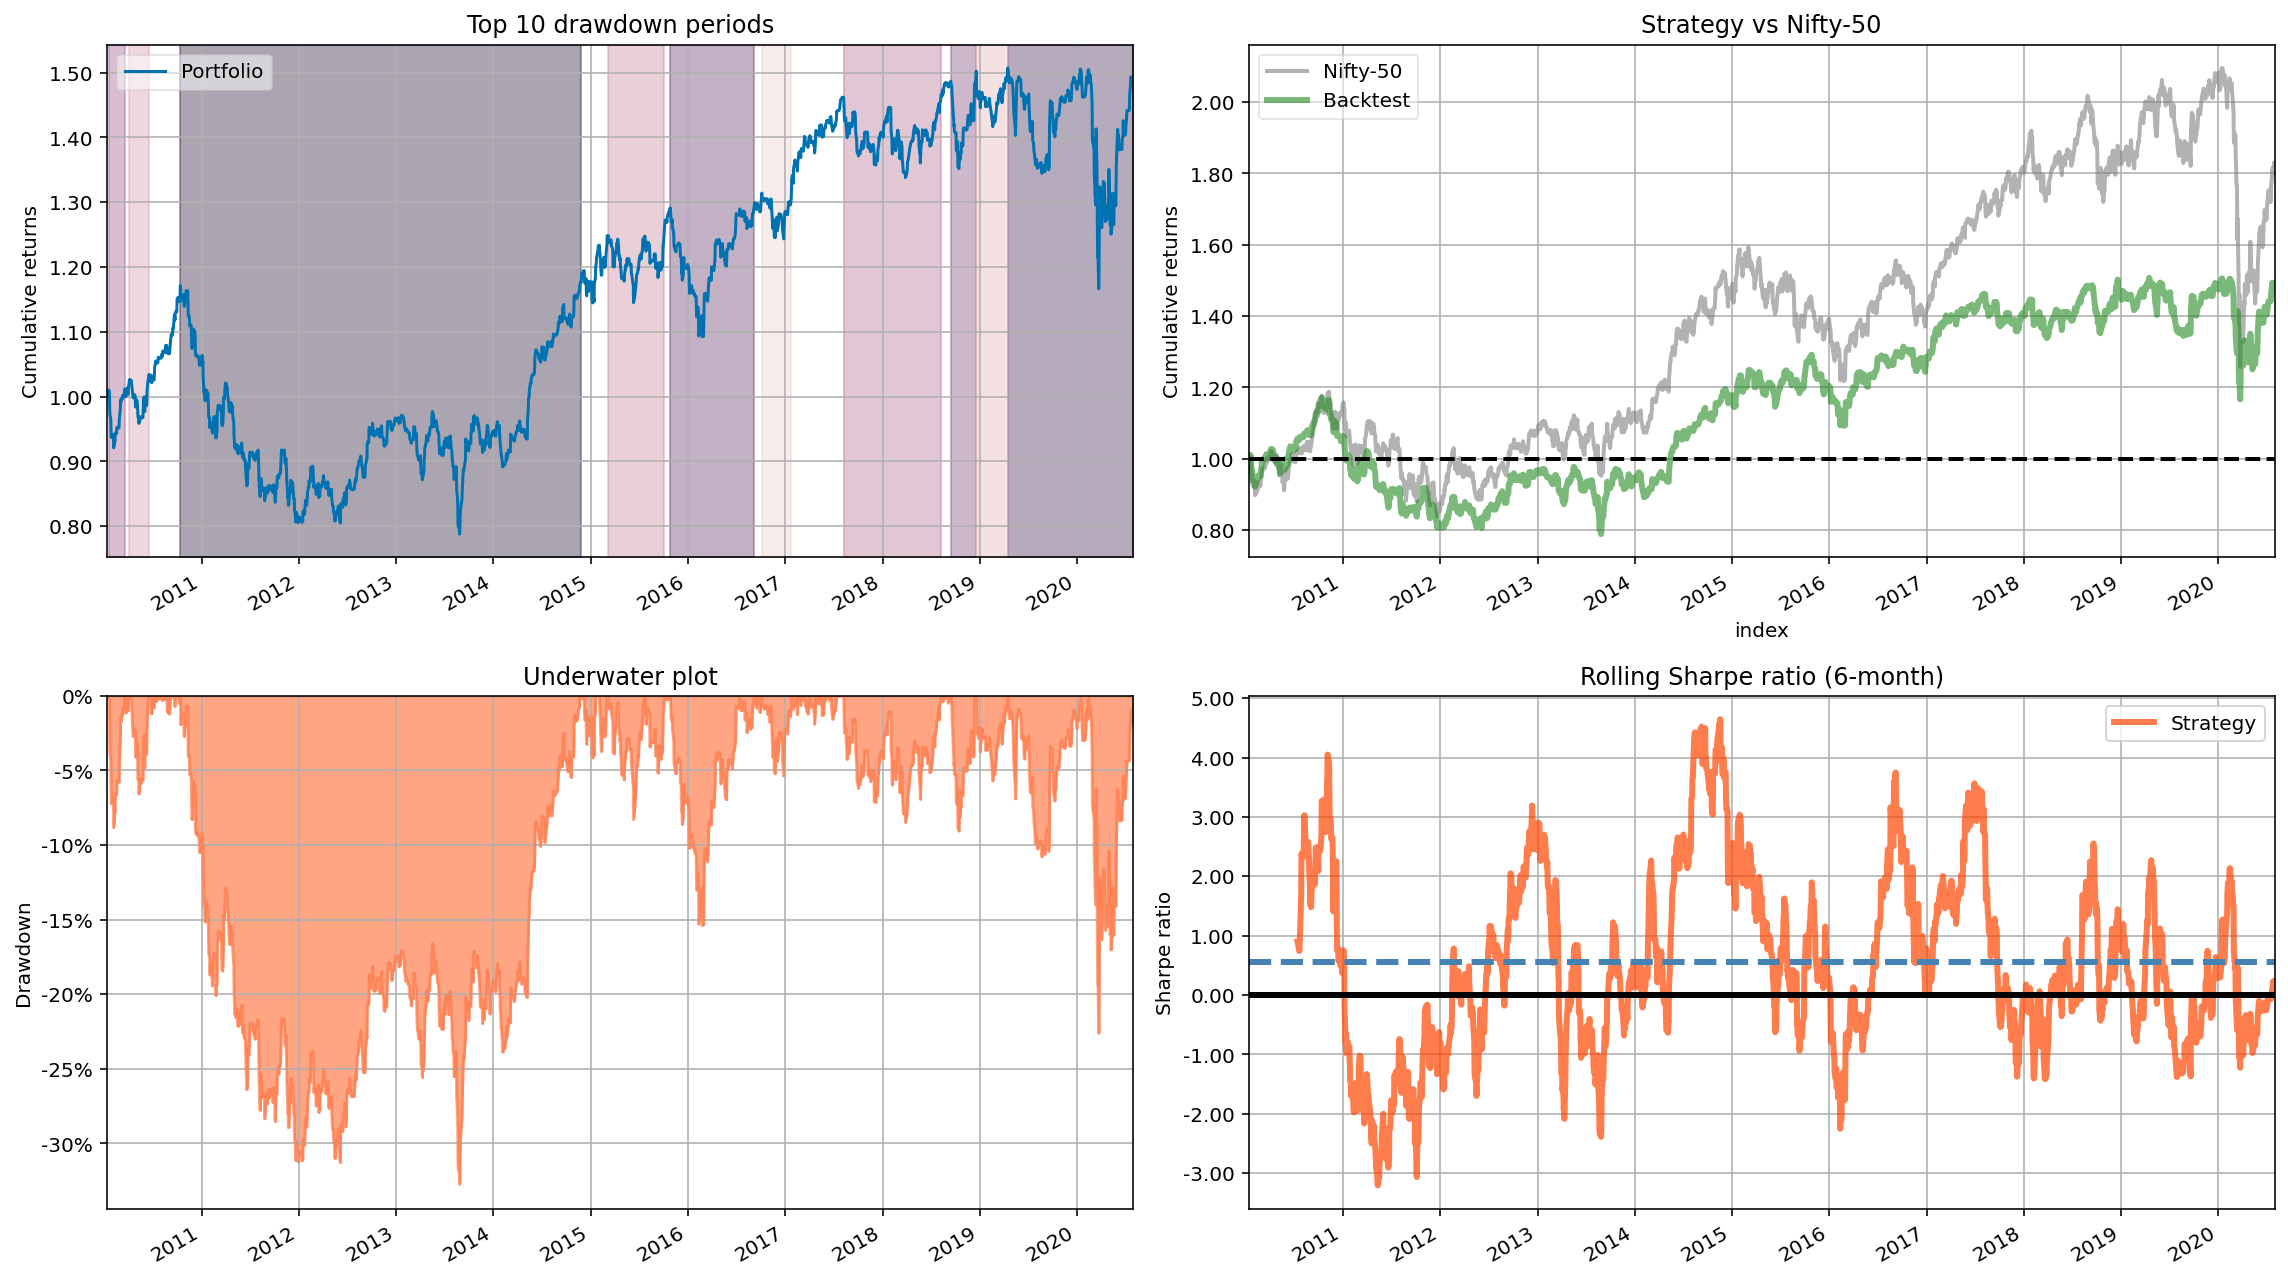

In [44]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()

pf.plot_drawdown_periods(returns=returns, ax=axes[0])
axes[0].grid(True)
pf.plot_rolling_returns(returns=returns,
                        factor_returns=benchmark_rets,
                        ax=axes[1], title='Strategy vs Nifty-50')
axes[1].grid(True)
pf.plot_drawdown_underwater(returns=returns, ax=axes[2])
axes[2].grid(True)
pf.plot_rolling_sharpe(returns=returns, ax=axes[3])
axes[3].grid(True)
# fig.suptitle('Strategy vs Nifty-50 (Buy and Hold)', fontsize=16, y=0.990)

plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('images/chart3', dpi=300)

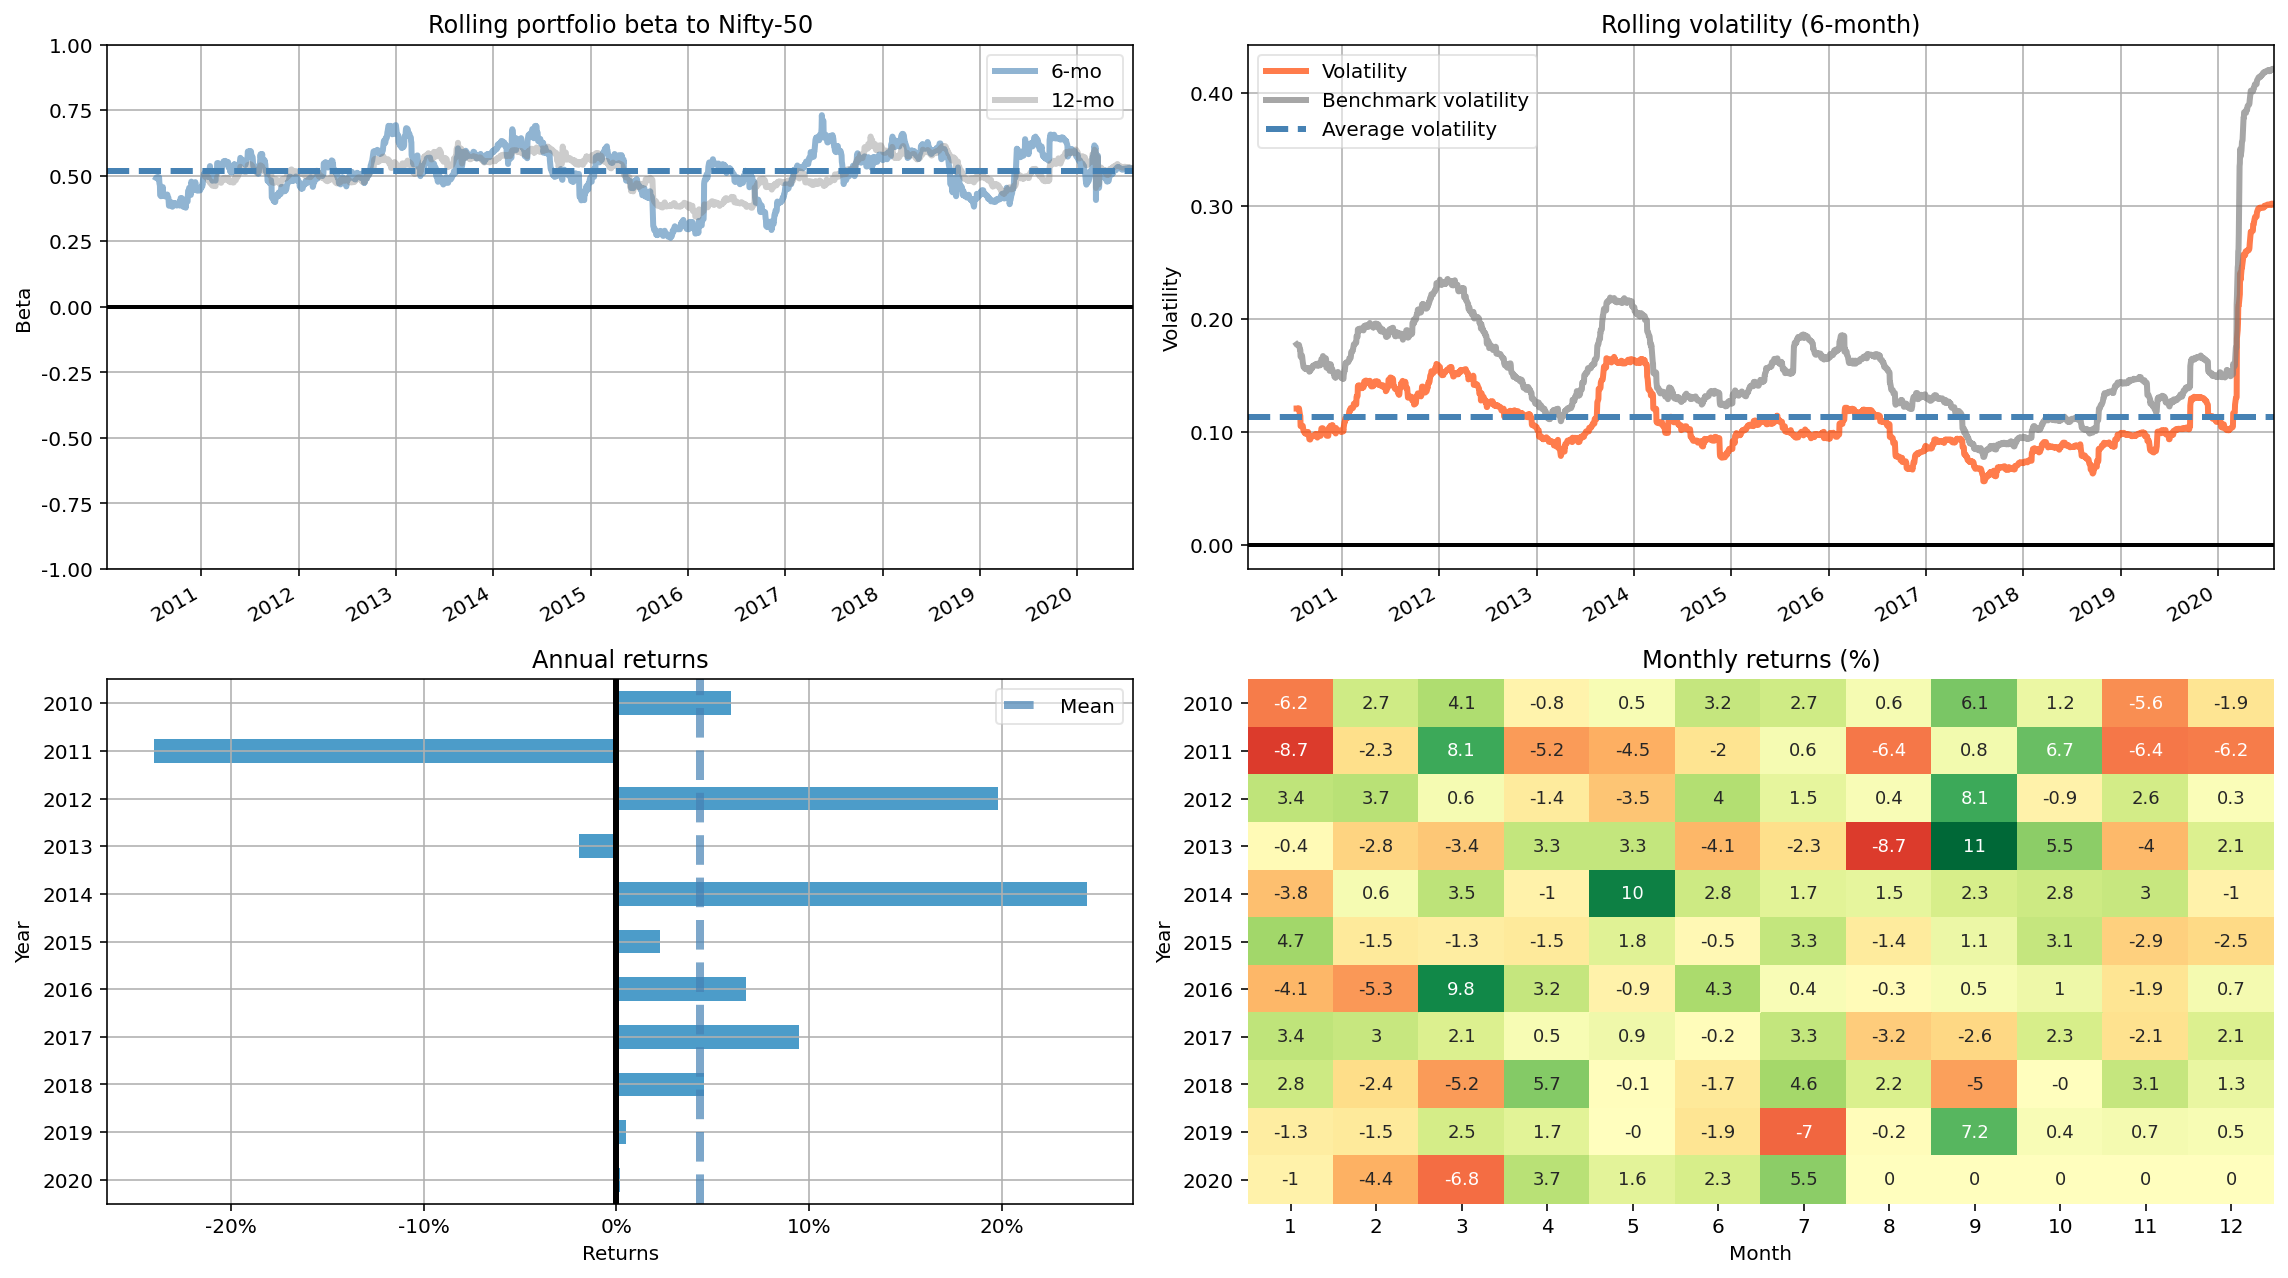

In [45]:
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()

pf.plot_rolling_beta(returns=returns, factor_returns=benchmark_rets, ax=axes[0])
axes[0].grid(True)

pf.plot_rolling_volatility(returns=returns, factor_returns=benchmark_rets,ax=axes[1])
axes[1].grid(True)

pf.plot_annual_returns(returns=returns, ax=axes[2])
axes[2].grid(True)

pf.plot_monthly_returns_heatmap(returns=returns, ax=axes[3],)
# fig.suptitle('BL Portfolio vs BSE-SENSEX - 2', fontsize=16, y=1.0)


plt.tight_layout()
plt.savefig('images/chart4', dpi=300)